Import Libraries


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np


Define Paths

In [3]:
train_dir = 'E:/Music Chord/Data70_30_ (75)/Train'
test_dir = 'E:/Music Chord/Data70_30_ (75)/Validation'


Data Preparation

In [4]:
# Image data generators with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 624 images belonging to 12 classes.
Found 276 images belonging to 12 classes.


Load the MobileNetV2 Model

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

from tensorflow.keras.layers import ELU

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = ELU(alpha=1.0)(x)  # ELU with alpha 1.0
predictions = Dense(12, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


Compile the Model

In [6]:
for layer in base_model.layers:
    layer.trainable = False


In [7]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Train the Model

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6703 - loss: 0.9336 - val_accuracy: 0.5580 - val_loss: 1.7189
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6177 - loss: 1.0130 - val_accuracy: 0.5507 - val_loss: 1.4545
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6463 - loss: 0.9363 - val_accuracy: 0.4746 - val_loss: 1.8465
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6885 - loss: 0.9726 - val_accuracy: 0.4928 - val_loss: 1.5396
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6533 - loss: 0.9583 - val_accuracy: 0.5761 - val_loss: 1.3777
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7137 - loss: 0.8349 - val_accuracy: 0.4855 - val_loss: 1.8018
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6845 - loss: 0.9141 - val_accuracy: 0.4275 - val_loss: 1.8554
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7094 - loss: 0.8763 - val_accuracy: 0.6848 - val_loss:

Evaluate the Model

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 955ms/step - accuracy: 0.6280 - loss: 1.1013
Test Accuracy: 62.32%


 Save the Model

In [13]:
# Save the trained model
model.save('E:/Music Chord/Models/MobileNetV2.h5')

print("Model saved to disk.")


Model saved to disk.


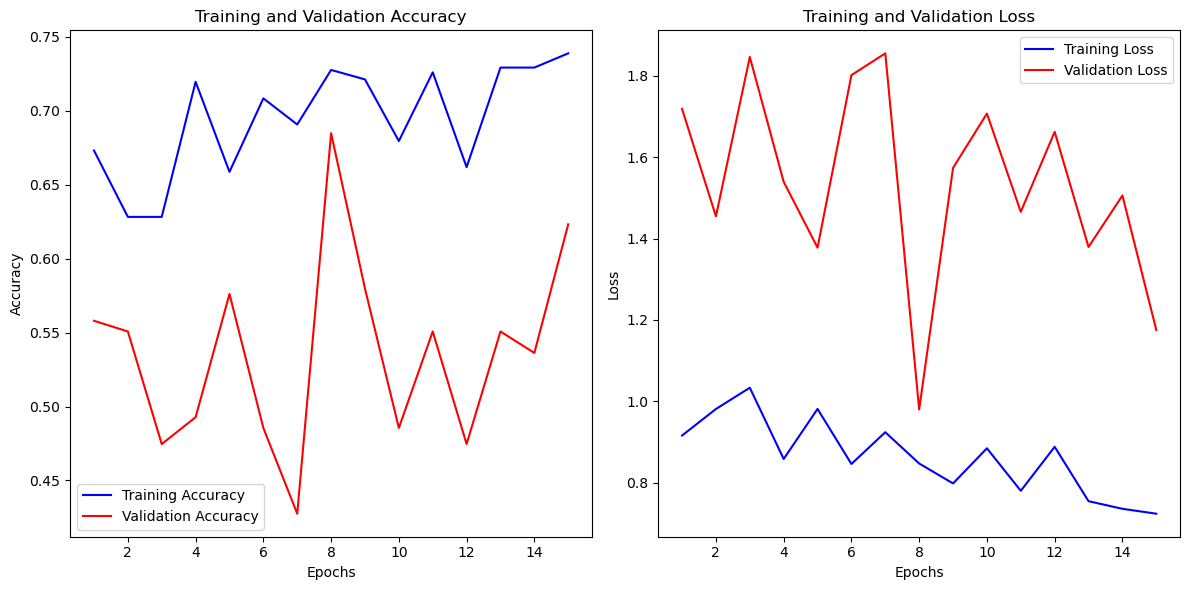

In [14]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss over epochs
def plot_history(history):
    # Retrieve training and validation accuracy and loss from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_history(history)


Found 276 images belonging to 12 classes.


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 986ms/step


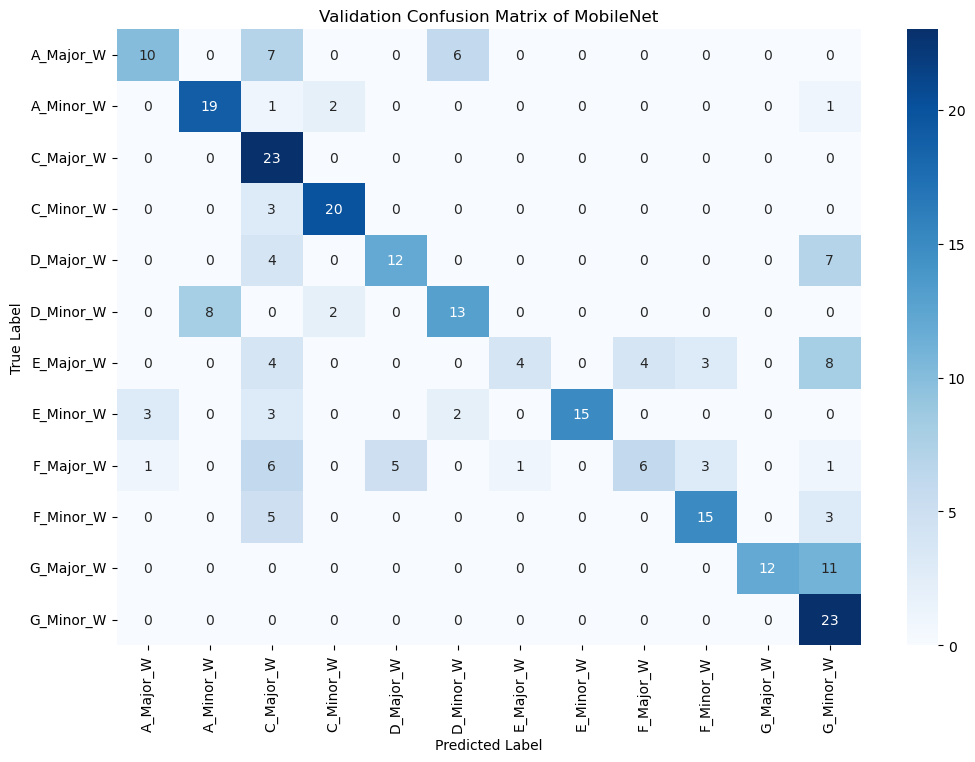

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the test directory and batch size
# test_dir = 'dataset/test'
batch_size = 32

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the trained model
model = load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Predict the labels for the test data
Y_pred = model.predict(test_generator, test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test data generator
y_true = test_generator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Confusion Matrix of MobileNet')
plt.show()


Piano Dataset of sub_classes Confusion Matrix and Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━

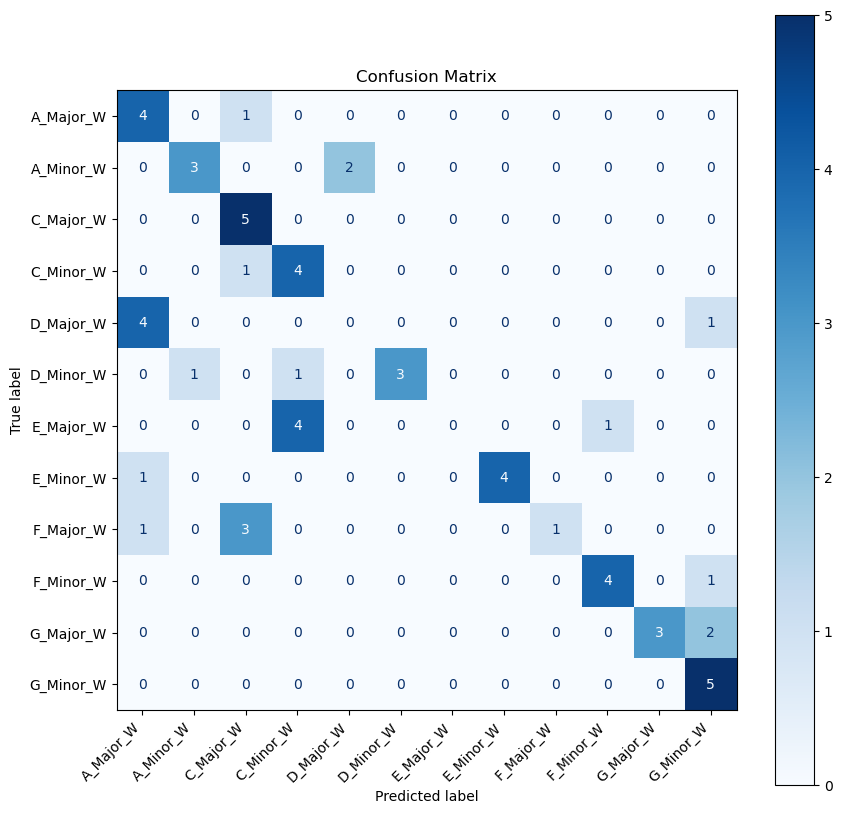

Accuracy: 60.00%


In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(train_generator.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/Data70_30_ (75)/Test2'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Guiter Dataset with sub_Folders , Confiction Matrix and accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

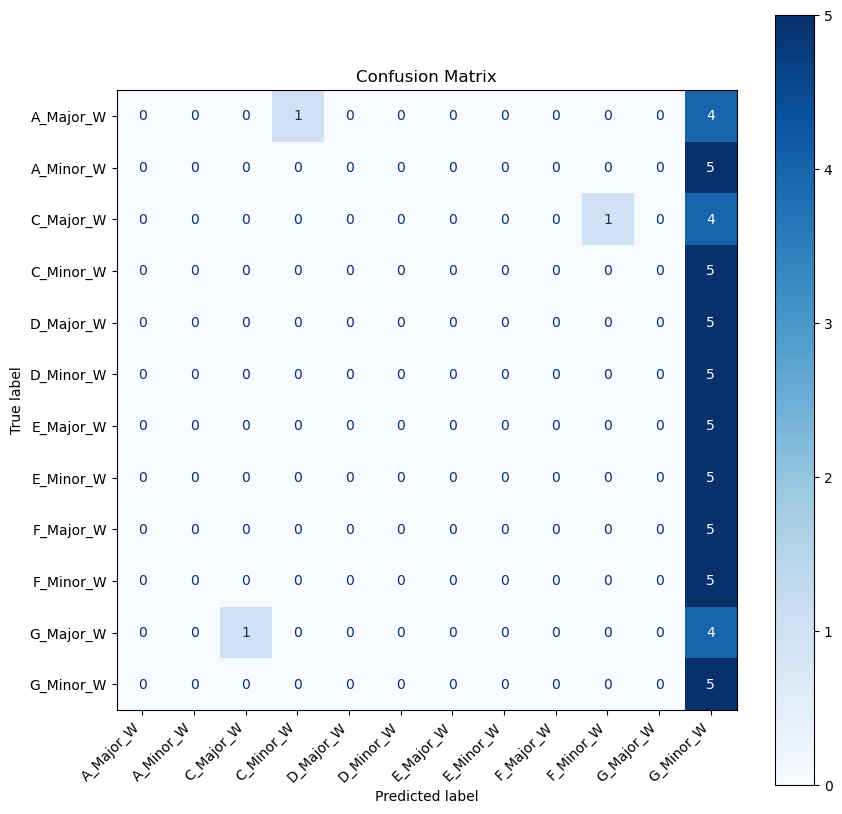

Accuracy: 8.33%


In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(train_generator.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/Giter_dataset(5)'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━

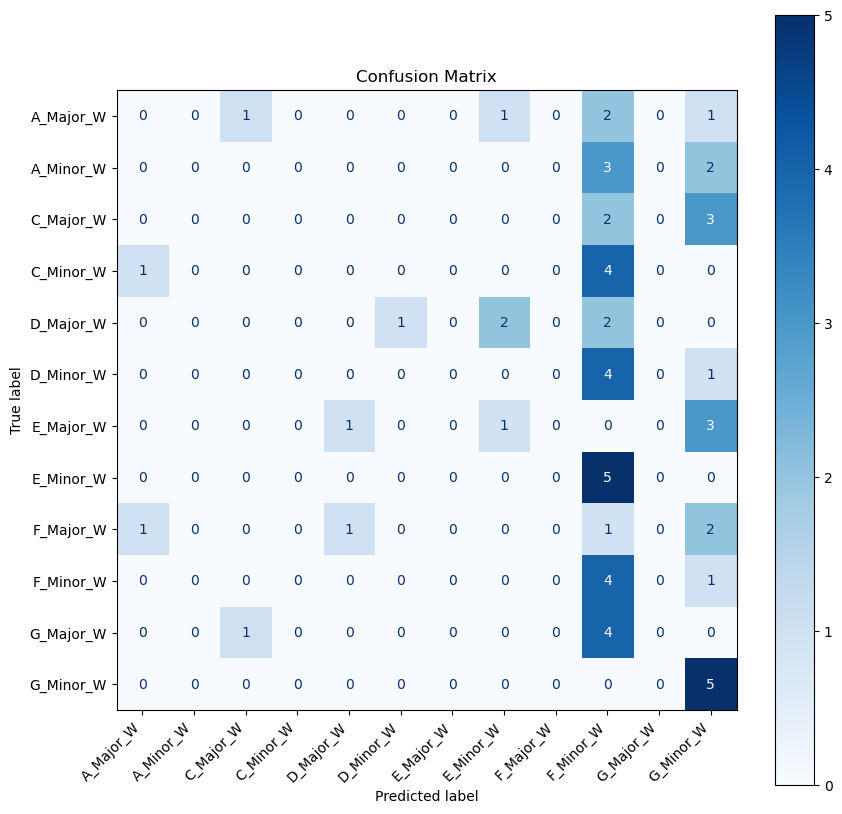

Accuracy: 15.00%


In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(train_generator.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/New'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Dataset of both Guiter And Piano

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━

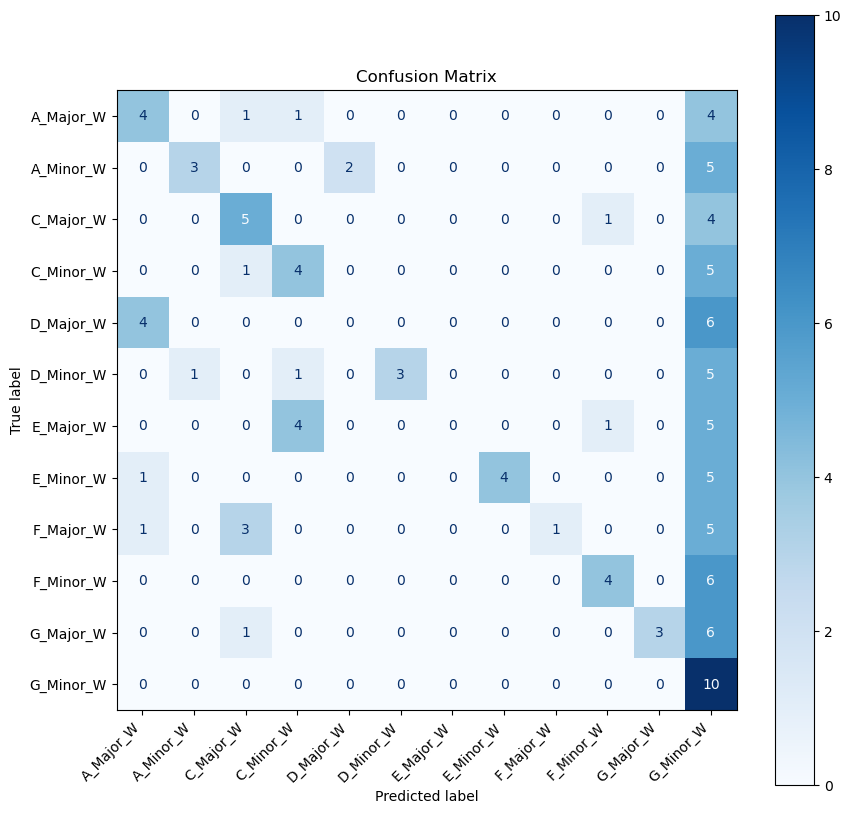

Accuracy: 34.17%


In [21]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(train_generator.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:\Music Chord\Both'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Images of all classes in single folder -Piano

Files in directory 'E:/Music Chord/Data70_30_ (75)/Test3': ['A_Major_W.png', 'A_Minor_W.png', 'C_Major_W.png', 'C_Minor_W.png', 'D_Major_W.png', 'D_Minor_W.png', 'E_Major_W.png', 'E_Minor_W.png', 'F_Major_W.png', 'F_Minor_W.png', 'G_Major_W.png', 'G_Minor_W.png']
Number of test images: 12
Number of test labels: 12
Test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Predicted labels: [ 2  3  2  3  4  3  3  5  2  9 11 11]
Accuracy: 41.67%


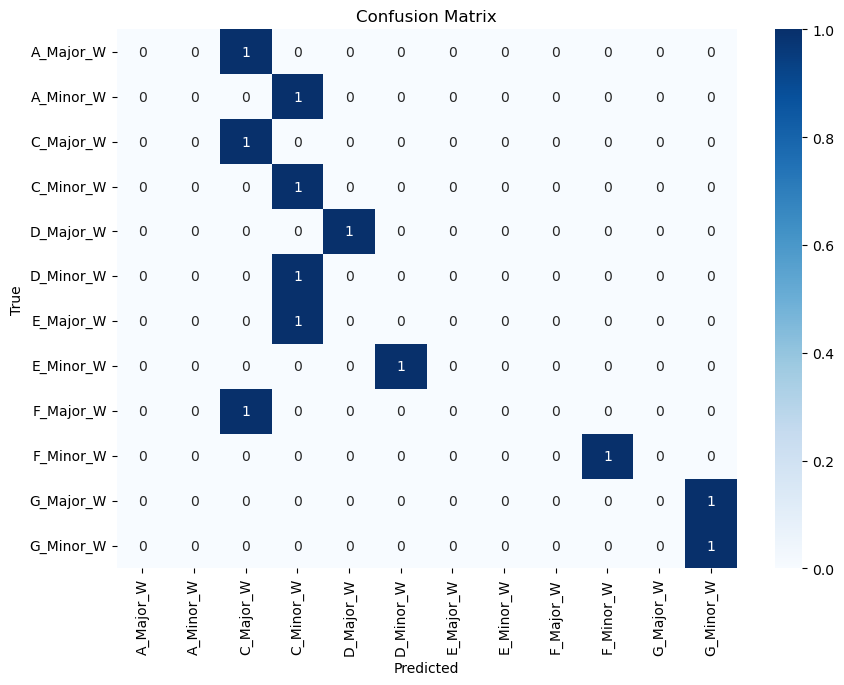

              precision    recall  f1-score   support

   A_Major_W       0.00      0.00      0.00         1
   A_Minor_W       0.00      0.00      0.00         1
   C_Major_W       0.33      1.00      0.50         1
   C_Minor_W       0.25      1.00      0.40         1
   D_Major_W       1.00      1.00      1.00         1
   D_Minor_W       0.00      0.00      0.00         1
   E_Major_W       0.00      0.00      0.00         1
   E_Minor_W       0.00      0.00      0.00         1
   F_Major_W       0.00      0.00      0.00         1
   F_Minor_W       1.00      1.00      1.00         1
   G_Major_W       0.00      0.00      0.00         1
   G_Minor_W       0.50      1.00      0.67         1

    accuracy                           0.42        12
   macro avg       0.26      0.42      0.30        12
weighted avg       0.26      0.42      0.30        12



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test3'
model_path = 'E:/Music Chord/Models/MobileNetV2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Load and preprocess test images
test_images = []
test_labels = []  # This should be a list of true labels for each test image
class_labels = ['A_Major_W', 'A_Minor_W', 'C_Major_W', 'C_Minor_W', 'D_Major_W', 'D_Minor_W',
                'E_Major_W', 'E_Minor_W', 'F_Major_W', 'F_Minor_W', 'G_Major_W', 'G_Minor_W']  # Define your classes here

# Print debug information about the files in the test directory
print(f"Files in directory '{test_dir}': {os.listdir(test_dir)}")

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)
            test_images.append(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename

            # Check if the entire filename (without extension) matches a class label
            if label_name in class_labels:
                test_labels.append(class_labels.index(label_name))
            else:
                print(f"Warning: '{label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

# Debug: Print out the true labels and predicted labels
print(f'True labels: {y_true}')
print(f'Predicted labels: {y_pred}')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


60 Images of all classes in single folder -Piano

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Accuracy: 41.67%


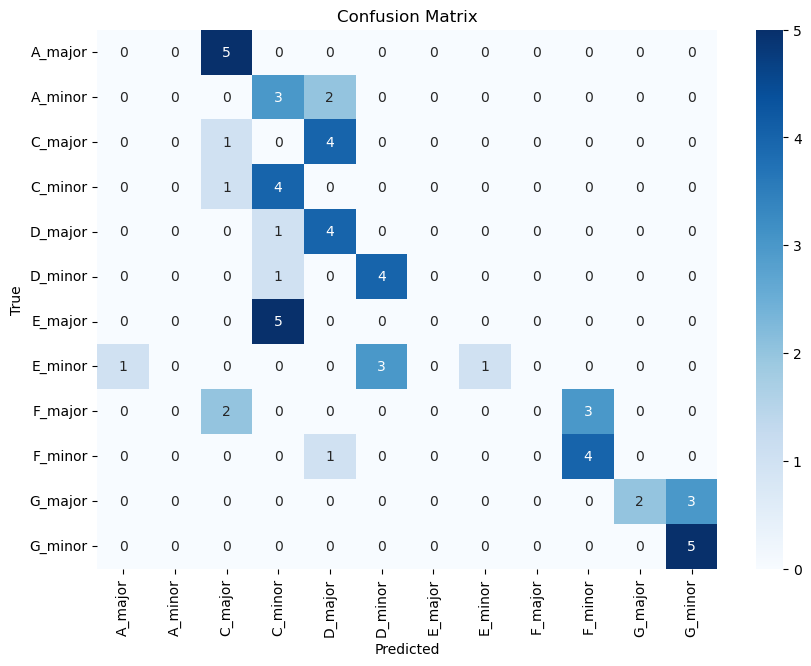

              precision    recall  f1-score   support

     A_major       0.00      0.00      0.00         5
     A_minor       0.00      0.00      0.00         5
     C_major       0.11      0.20      0.14         5
     C_minor       0.29      0.80      0.42         5
     D_major       0.36      0.80      0.50         5
     D_minor       0.57      0.80      0.67         5
     E_major       0.00      0.00      0.00         5
     E_minor       1.00      0.20      0.33         5
     F_major       0.00      0.00      0.00         5
     F_minor       0.57      0.80      0.67         5
     G_major       1.00      0.40      0.57         5
     G_minor       0.62      1.00      0.77         5

    accuracy                           0.42        60
   macro avg       0.38      0.42      0.34        60
weighted avg       0.38      0.42      0.34        60

Misclassified sample: True label = A_major, Predicted label = C_major
Misclassified sample: True label = A_major, Predicted label = C

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test'
model_path = 'E:/Music Chord/Models/MobileNetV2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


60 images of Guiter in single folder 

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 125 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025EF5D26200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Accuracy: 8.33%


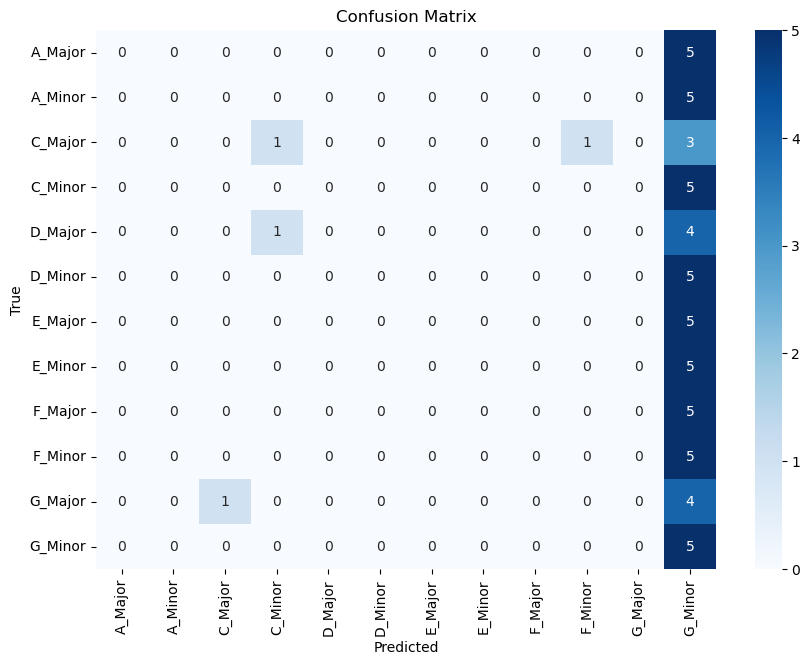

              precision    recall  f1-score   support

     A_Major       0.00      0.00      0.00         5
     A_Minor       0.00      0.00      0.00         5
     C_Major       0.00      0.00      0.00         5
     C_Minor       0.00      0.00      0.00         5
     D_Major       0.00      0.00      0.00         5
     D_Minor       0.00      0.00      0.00         5
     E_Major       0.00      0.00      0.00         5
     E_Minor       0.00      0.00      0.00         5
     F_Major       0.00      0.00      0.00         5
     F_Minor       0.00      0.00      0.00         5
     G_Major       0.00      0.00      0.00         5
     G_Minor       0.09      1.00      0.16         5

    accuracy                           0.08        60
   macro avg       0.01      0.08      0.01        60
weighted avg       0.01      0.08      0.01        60

Misclassified sample: True label = A_Major, Predicted label = G_Minor
Misclassified sample: True label = A_Major, Predicted label = G

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test4'
model_path = 'E:/Music Chord/Models/MobileNetV2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_Major', 'A_Minor', 'C_Major', 'C_Minor', 'D_Major', 'D_Minor',
                'E_Major', 'E_Minor', 'F_Major', 'F_Minor', 'G_Major', 'G_Minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


30-30 Images of Panio and Guiter

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Accuracy: 30.00%


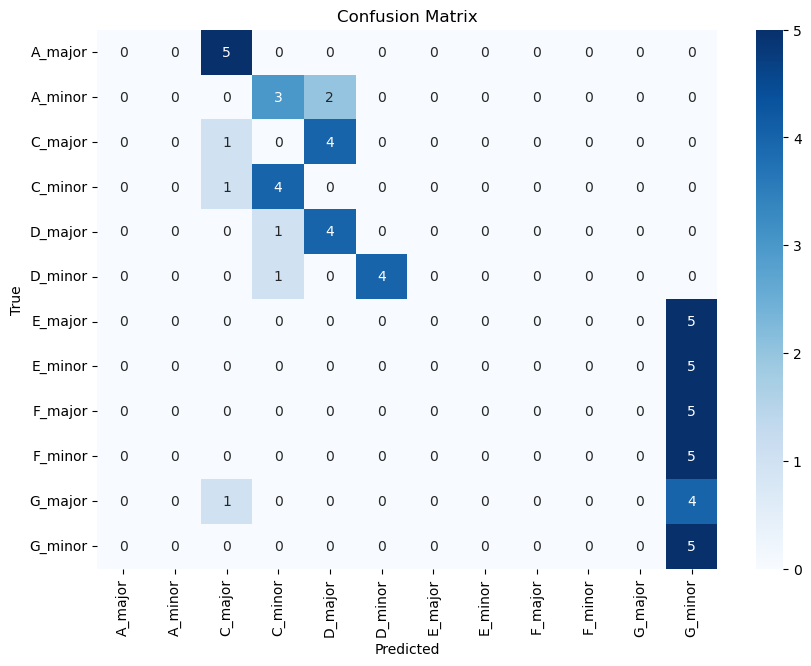

              precision    recall  f1-score   support

     A_major       0.00      0.00      0.00         5
     A_minor       0.00      0.00      0.00         5
     C_major       0.12      0.20      0.15         5
     C_minor       0.44      0.80      0.57         5
     D_major       0.40      0.80      0.53         5
     D_minor       1.00      0.80      0.89         5
     E_major       0.00      0.00      0.00         5
     E_minor       0.00      0.00      0.00         5
     F_major       0.00      0.00      0.00         5
     F_minor       0.00      0.00      0.00         5
     G_major       0.00      0.00      0.00         5
     G_minor       0.17      1.00      0.29         5

    accuracy                           0.30        60
   macro avg       0.18      0.30      0.20        60
weighted avg       0.18      0.30      0.20        60

Misclassified sample: True label = A_major, Predicted label = C_major
Misclassified sample: True label = A_major, Predicted label = C

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test5'
model_path = 'E:/Music Chord/Models/MobileNetV2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


Single image predection - Piano


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Found 60 images belonging to 12 classes.
Predicted class: C_Major_W
True class label: C_Major_W
Is the prediction correct? Yes
Accuracy of the prediction: 100.00%


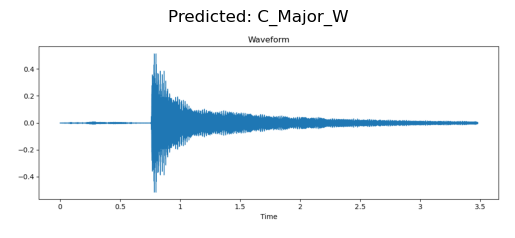

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved model
model = tf.keras.models.load_model('E:/Music Chord/Models/MobileNetV2.h5')

# Path to the image you want to test
image_path = 'E:/Music Chord/Data70_30_ (75)/Test3/C_Major_W.png'

# Preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image (same as training)
    return img_array

# Extract true class label from the image filename
def extract_true_class_label(image_path):
    # Assuming the image filename contains the class label
    return os.path.splitext(os.path.basename(image_path))[0]

# Preprocess the input image
image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Load the test dataset to get the class labels
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    'E:/Music Chord/Data70_30_ (75)/Test2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_generator.class_indices.keys())

# Print the predicted class
predicted_class_label = class_labels[predicted_class]
print(f'Predicted class: {predicted_class_label}')

# Get the true class label
true_class_label = extract_true_class_label(image_path)
print(f'True class label: {true_class_label}')

# Check if the prediction is correct
is_correct = (predicted_class_label.lower() == true_class_label.lower())
print(f'Is the prediction correct? {"Yes" if is_correct else "No"}')

# Print accuracy
accuracy = 100.0 if is_correct else 0.0
print(f'Accuracy of the prediction: {accuracy:.2f}%')

# Optional: Display the image
img = load_img(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

# # Debug: Print the directory structure and image path
# print(f'Directory containing the image: {os.path.dirname(image_path)}')
# print(f'Base name of the directory: {os.path.basename(os.path.dirname(image_path))}')
# print(f'Image filename: {os.path.basename(image_path)}')
# print(f'Extracted true class label: {true_class_label}')